In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from time import time
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

sample = pd.read_csv('../data/preprocessed/concat.csv', index_col=0)
sample['preprocessed'] = sample['preprocessed'] + ' '
sample.dropna(axis=0, inplace=True)

Loading dataset...
done in 0.172s.
Extracting tf features for LDA...
done in 1873.265s.
Fitting LDA models with tf features, n_features=10000...
done in 431.372s.


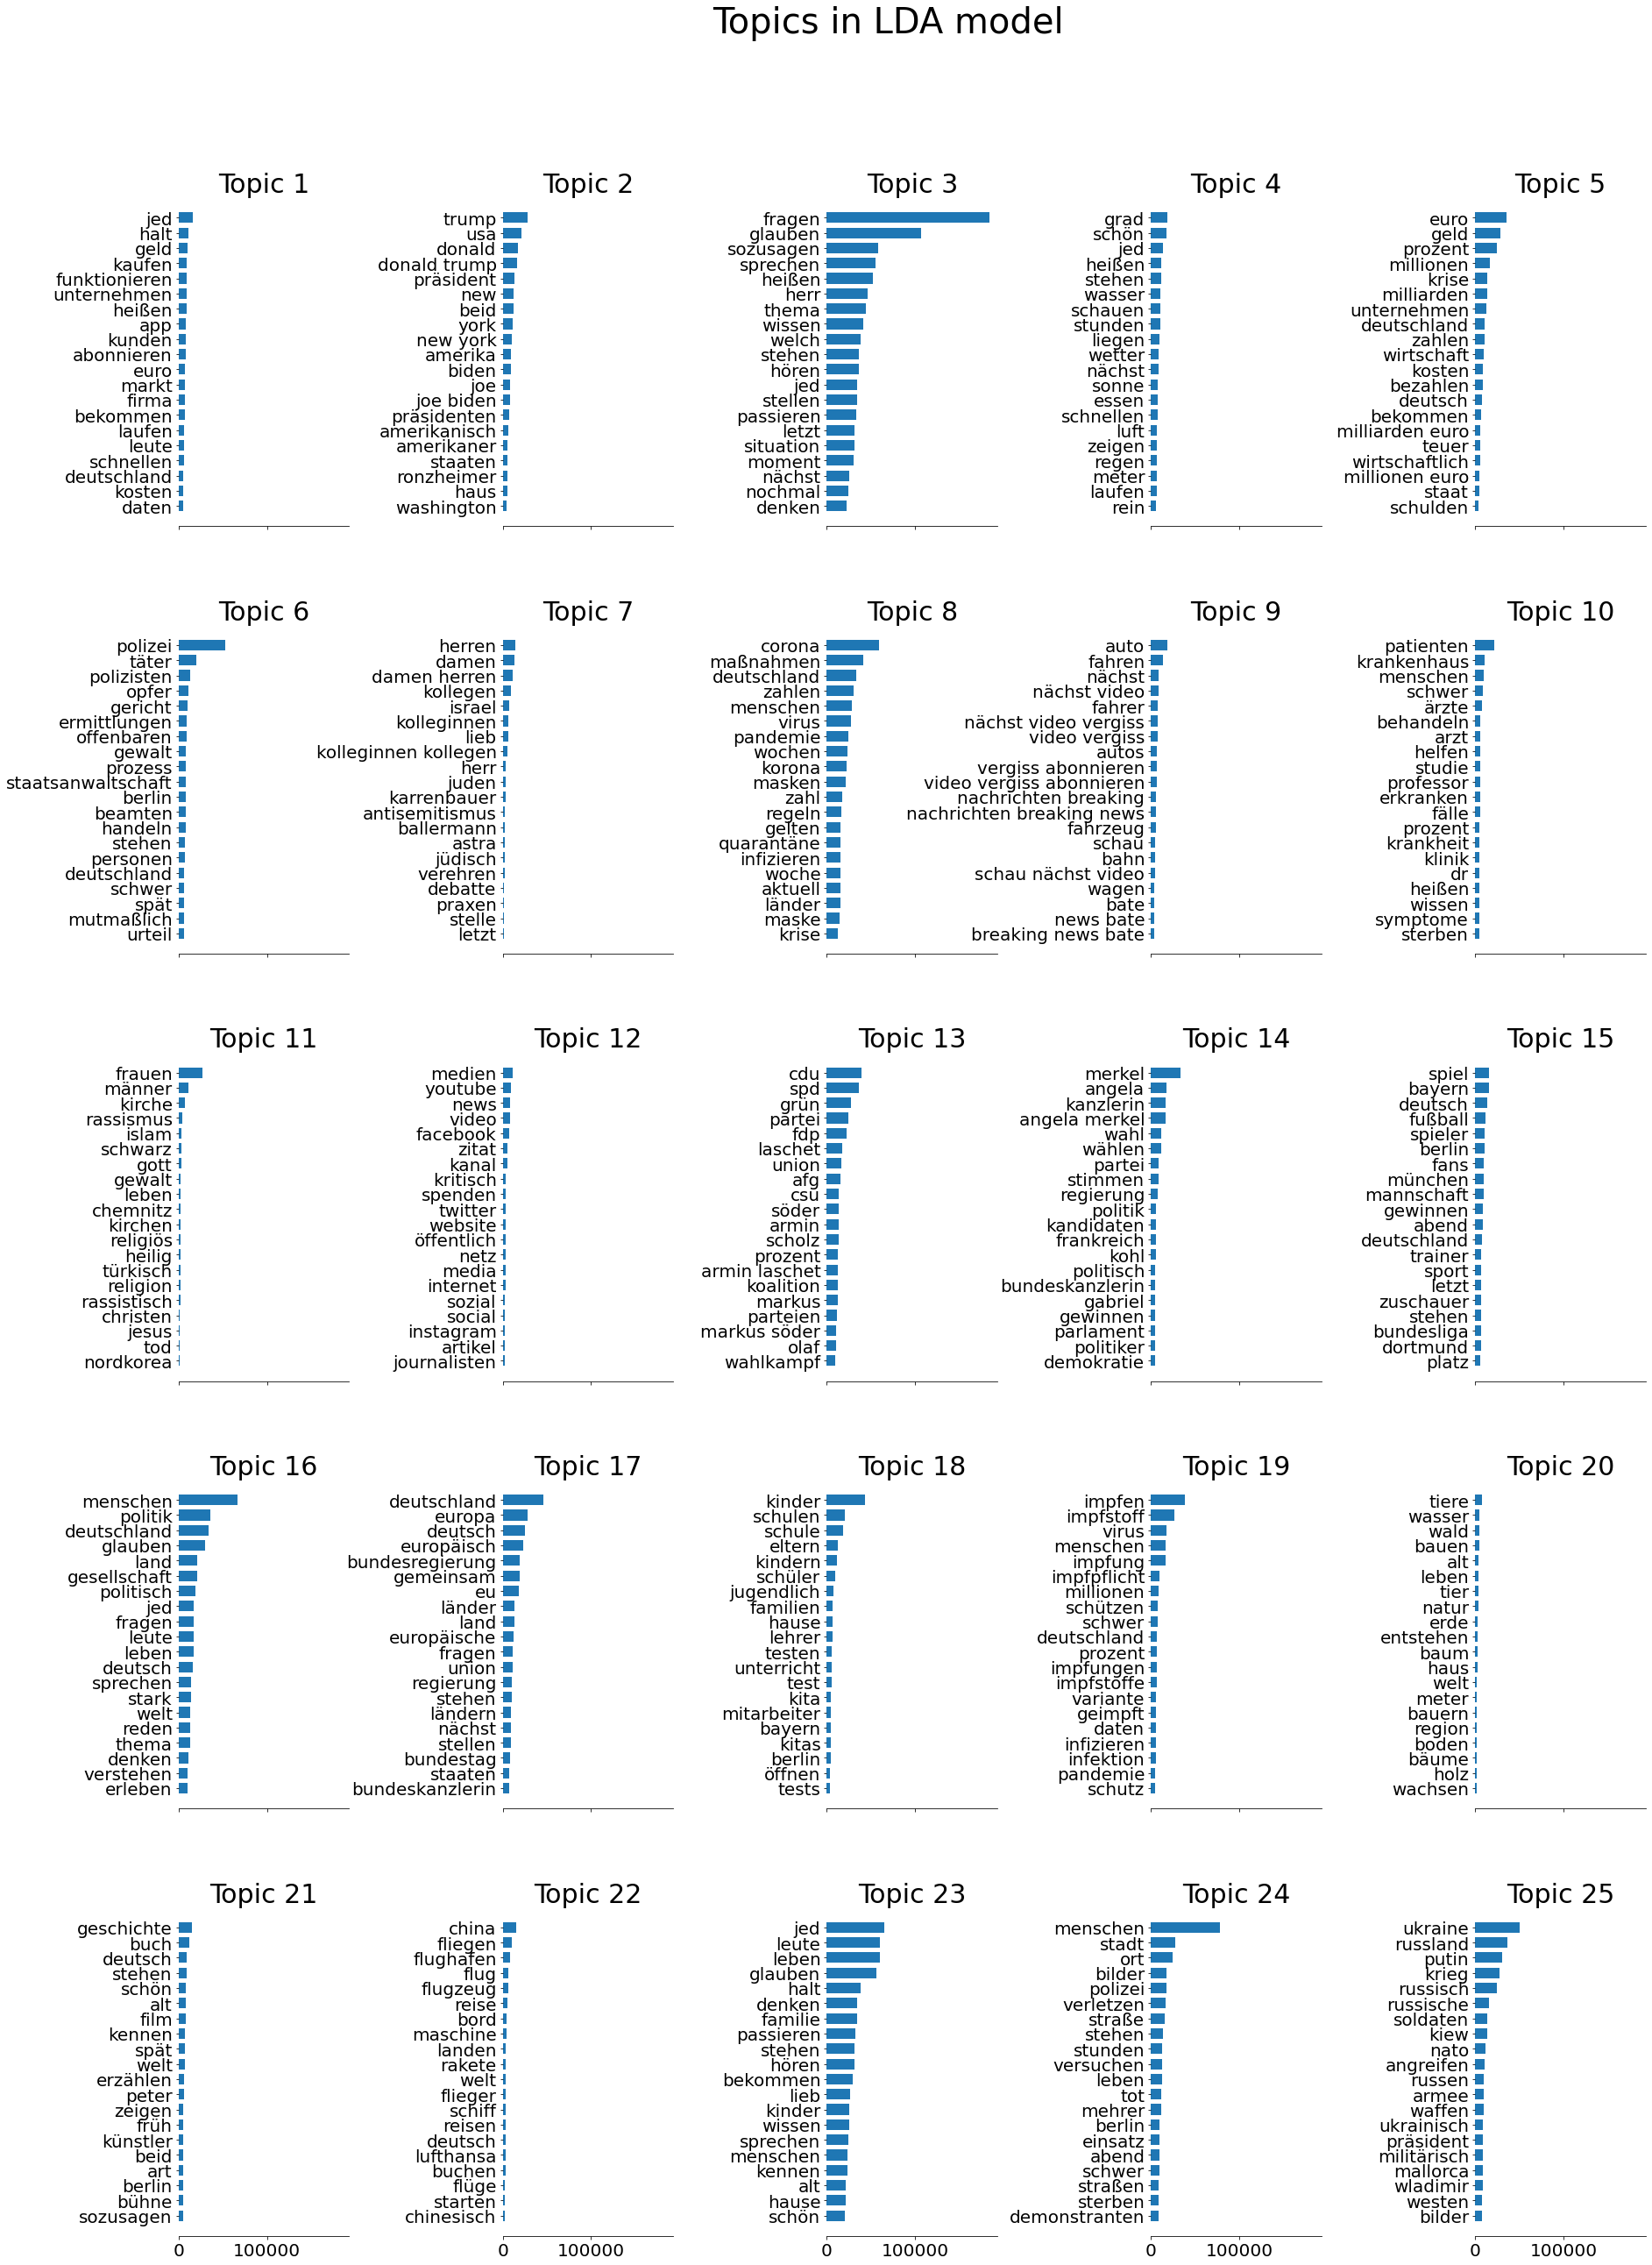

In [3]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# License: BSD 3 clause

n_features = 10000
n_components = 25
n_top_words = 20

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(5, 5, figsize=(30, 38), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

print("Loading dataset...")
t0 = time()
data = sample['preprocessed'].tolist()
data_samples = data
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(
    max_df=0.9, min_df=10, max_features=n_features, stop_words='english', ngram_range=(1,3)
)
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print(
    "Fitting LDA models with tf features, n_features=%d..."
    % (n_features),
)
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=10,
    learning_method="online",
    learning_offset=45.0,
    learning_decay=0.5,
    random_state=0,
    n_jobs=-1
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

In [4]:
# Define Search Param
search_params = {'n_components': [15, 25, 35], 'learning_decay': [0.4, 0.5, 0.6], 'learning_offset':[40.0, 45.0, 50.0]}

# Init the Model
lda = LatentDirichletAllocation(
    max_iter=10,
    learning_method="online",
    random_state=0,
    n_jobs=-1
)

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params, verbose=3)

# Do the Grid Search
model.fit(tf)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


Process LokyProcess-24:
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.8/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/hs/GitHub/media_bias_video_journalism/.venv/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py", line 442, in _process_worker
    del r
KeyboardInterrupt


In [4]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(tf))

Best Model's Params:  {'learning_decay': 0.5, 'learning_offset': 45.0, 'n_components': 25}
Best Log Likelihood Score:  -7918462.9442712115
Model Perplexity:  549.6367186007102


In [1]:
topic_dict = {
    0: 'Misc1',
    1: 'Ampelregierung',
    2: 'Innenpolitik',
    3: 'Familie',
    4: 'Gender',
    5: 'Wahlen',
    6: 'Justiz',
    7: 'Medien',
    8: 'Impfung',
    9: 'Abspann',
    10: 'Live',
    11: 'Lokal',
    12: 'Befragung',
    13: 'Krieg',
    14: 'Angela Merkel',
    15: 'Fußball',
    16: 'Ukrainekonflikt',
    17: 'Wirtschaft',
    18: 'Schule',
    19: 'COVID-19 Maßnahmen',
    20: 'Interview',
    21: 'USA',
    22: 'Misc2',
    23: 'International',
    24: 'CDU/CSU',
}

In [8]:
best_lda_model = lda

In [62]:
df = pd.read_csv('../data/samples/sample300.csv', index_col=0)
df.dropna(subset=['preprocessed'], inplace=True)
df_vectorized = tf_vectorizer.transform(df['preprocessed'].to_list())
lda_output = pd.DataFrame(lda.transform(df_vectorized))
lda_output['dominant topic'] = np.argmax(lda_output.values, axis=1)
lda_output['id'] = df['id'].to_list()
lda_output.set_index('id')


test = df.merge(lda_output, how='outer', on='id')
test['dominant topic'] = test['dominant topic'].apply(lambda row: topic_dict[row])

test.rename(columns = topic_dict, inplace = True)

In [63]:
test

,medium,title,id,duration,transcript,preprocessed,Misc1,Ampelregierung,Innenpolitik,Familie,...,Ukrainekonflikt,Wirtschaft,Schule,COVID-19 Maßnahmen,Interview,USA,Misc2,International,CDU/CSU,dominant topic
0,Junge Freiheit,"Alice Weidel: ""Appell an alle Bundestagsabgeor...",CYud2Ii8KXc,2:51,[Musik] freude sie sind dritte kraft geworden ...,freude dritt kraft afg fulminant ergebnis hinl...,0.000769,0.000769,0.264072,0.035662,...,0.000769,0.000769,0.000769,0.000769,0.055633,0.000769,0.000769,0.039516,0.000769,Wahlen
1,NachDenkSeiten,Internet-Zensur: Schäuble bekämpft das Recht a...,ib4o5Bs2TkQ,8:22,[Musik] nachdenkseiten die kritische website i...,kritisch website internetzensur schäuble bekäm...,0.000305,0.000305,0.138707,0.000305,...,0.000305,0.031560,0.006677,0.000305,0.000305,0.000305,0.035233,0.049024,0.000305,Medien
2,DER SPIEGEL,NSA-Chef bei IT-Konferenz: Auftritt voller Zwi...,6WN7M2G6L1w,1:31,auf der konferenz black hat in las vegas stell...,konferenz black vegas stellen chef nsa general...,0.001429,0.001429,0.793036,0.001429,...,0.001429,0.001429,0.001429,0.001429,0.001429,0.093347,0.001429,0.001429,0.001429,Innenpolitik
3,DER SPIEGEL,Tea Time im Tesla Model 3: Wir drehen eine Run...,BuiPc_QaPBY,10:42,[Musik] [Applaus] [Musik] panico heute ist tea...,panico tea time denken testen amerikanisch aut...,0.127466,0.000328,0.000328,0.000328,...,0.000328,0.645638,0.000328,0.000328,0.000328,0.027478,0.000328,0.011606,0.000328,Wirtschaft
4,DER SPIEGEL,Zwangsräumung statt Enteignung | SPIEGEL TV,i9DBAcYelXU,6:59,gut und willkommen zu spiegel tv laut un sozia...,willkommen un sozialpakt wohnen menschenrecht ...,0.000455,0.000455,0.000455,0.240554,...,0.000455,0.358070,0.000455,0.000455,0.062383,0.000455,0.067450,0.000455,0.000455,Wirtschaft
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,Junge Freiheit,Spot: Deutsche Geschichte für junge Leser,i5isR0hf7v0,2:52,woher kommen wir wer sind wir und wo gehen wir...,ereignisse vergangenheit liefern antworten fra...,0.000690,0.000690,0.000690,0.000690,...,0.000690,0.000690,0.015742,0.000690,0.000690,0.000690,0.098897,0.000690,0.000690,Krieg
1496,NachDenkSeiten,Hartz-IV-Urteil: Angriffe auf das Existenzmini...,-Rccm0NlWTA,11:46,[Musik] nachdenkseiten die kritische website h...,kritisch website urteil angriffe existenzminim...,0.000221,0.011098,0.163521,0.000221,...,0.075768,0.143908,0.000221,0.000221,0.000221,0.000221,0.019281,0.008185,0.000221,Medien
1497,ZDFheute Nachrichten,Debatte über Lockdown-Verlängerung | Markus La...,_G56rchtBns,31:35,wenn ja wann ist hamburgs arbeit mit diesen be...,hamburgs arbeit beschränkungen bewegungsradius...,0.185514,0.000062,0.159594,0.000062,...,0.003919,0.042422,0.064085,0.261442,0.138152,0.000062,0.000062,0.006090,0.000062,COVID-19 Maßnahmen
1498,NachDenkSeiten,Davos – Willkommen im Paralleluniversum der „E...,KvQTDUQtNxM,7:34,[Musik] nachdenkseiten die kritische website d...,kritisch website davos willkommen paralleluniv...,0.000388,0.000388,0.099432,0.000388,...,0.000388,0.159691,0.000388,0.000388,0.000388,0.034007,0.000388,0.000388,0.000388,Medien


In [58]:
test['dominant topic'].value_counts()

Innenpolitik          148
Medien                138
Wahlen                128
COVID-19 Maßnahmen    106
Live                   98
Wirtschaft             92
Misc1                  89
Misc2                  82
Justiz                 82
Ukrainekonflikt        80
Krieg                  72
Interview              62
Fußball                60
Familie                58
Befragung              50
Ampelregierung         38
Impfung                30
USA                    21
Angela Merkel          17
Gender                 13
International          12
Abspann                12
Schule                  7
CDU/CSU                 4
Lokal                   1
Name: dominant topic, dtype: int64

In [59]:
test.to_csv('../data/labeled/labeled300.csv')

In [39]:
import joblib
joblib.dump(lda, '../data/lda_model.pkl')

['../data/lda_model.pkl']

In [42]:
temp1 = joblib.load('../data/lda_model.pkl')
temp1.get_params()

In [44]:
joblib.dump(tf_vectorizer, '../data/cv_model.pkl')

['../data/cv_model.pkl']

In [45]:
temp2 = joblib.load('../data/cv_model.pkl')
temp2.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 0.9,
 'max_features': 1000,
 'min_df': 10,
 'ngram_range': (1, 2),
 'preprocessor': None,
 'stop_words': 'english',
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [ ]:
df = pd.read_csv('../data/labeled/labeled300.csv')
df.iloc[0]